In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
all_data = pd.read_csv("Fnames_soilM_interp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','tsince_start']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3['DateTime'] = pd.to_datetime(lineCSN_M3['DateTime'])
lineCSN_M3.set_index('DateTime',inplace=True)


/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#Generate linking column
lineCSN_M3['file_name'] = lineCSN_M3['file_name'].apply(lambda x: x[2:])

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
lineCSN_M3.head()

,file_name,M3_20_Avg_interp,tsince_start
DateTime,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,21488.0
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,21548.0
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,21608.0
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,21668.0
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,21728.0


Load the feature dfs we just made

In [5]:
mean = pd.read_csv('mean')
mean.name = "mean"
median = pd.read_csv('median')
median.name = "median"
energy = pd.read_csv('energy')
energy.name = "energy"
iqr = pd.read_csv('iqr')
iqr.name = "iqr"
kurtosis = pd.read_csv('kurtosis')
kurtosis.name = "kurtosis"
rms = pd.read_csv('rms')
rms.name = "rms"
skew = pd.read_csv('skew')
skew.name = "skew"
sma_1_comp = pd.read_csv('sma_1_comp')
sma_1_comp.name = "sma_1_omp"
std = pd.read_csv('std')
std.name = "std"
Z = pd.read_csv('Z')
Z.name = "Z"
variance = pd.read_csv('variance')
variance.name = "var"
xcrossing = pd.read_csv('xcrossing_rate')
xcrossing.name = "xcrossing_rate"
minmax = pd.read_csv('minmax')
minmax.name = "minmax"
mad = pd.read_csv('mad')
mad.name = "mad"
cav = pd.read_csv('cav')
cav.name = "cav"

In [6]:
features = [mean,median,cav,Z,energy,skew,rms,mad,sma_1_comp,std,variance,xcrossing,minmax,iqr,kurtosis]

In [7]:
mean.head()

,channel_75,channel_76,channel_77,channel_78,channel_79,channel_80,channel_81,channel_82,channel_83,channel_84,...,channel_86,channel_87,channel_88,channel_89,channel_90,channel_91,channel_92,channel_93,channel_94,file_name
0,11.681328,11.297560,10.565713,10.651578,9.927648,10.649434,11.528420,12.121641,12.656151,15.255091,...,16.723557,17.106794,17.401350,18.916747,17.739294,18.236246,18.532227,14.985069,14.814697,20160805180738_40_Hz_LineCSN.mseed
1,11.566667,11.367564,10.293708,10.528026,10.187237,10.394019,10.176871,11.829739,12.520605,13.665388,...,15.142217,15.262201,15.716973,17.121646,15.819953,16.022636,19.865663,16.466882,15.095997,20160805180838_40_Hz_LineCSN.mseed
2,17.457526,16.757426,14.713631,15.279337,15.348863,15.728186,16.027678,17.240832,18.369659,19.865462,...,23.811905,24.183990,23.955821,27.518926,22.556312,23.323985,24.246977,23.410367,20.746625,20160805180938_40_Hz_LineCSN.mseed
3,22.503722,19.208751,17.648510,18.175225,18.467215,18.466986,19.151163,21.811650,22.420826,23.606734,...,28.118455,28.151359,24.944283,24.831824,22.715120,24.763001,25.123822,24.214795,21.177069,20160805181038_40_Hz_LineCSN.mseed
4,7.909541,7.508461,6.932315,7.417068,7.180079,7.608237,7.936308,9.298768,9.420749,9.748277,...,10.862061,10.854751,9.860103,9.708139,9.775488,10.243657,10.200908,9.650366,8.944905,20160805181138_40_Hz_LineCSN.mseed


### Testing merge ability

In [8]:
merged_mean = pd.merge(lineCSN_M3,mean,on='file_name')
merged_mean.head()

,file_name,M3_20_Avg_interp,tsince_start,channel_75,channel_76,channel_77,channel_78,channel_79,channel_80,channel_81,...,channel_85,channel_86,channel_87,channel_88,channel_89,channel_90,channel_91,channel_92,channel_93,channel_94
0,20160805180738_40_Hz_LineCSN.mseed,0.202000,21488.0,11.681328,11.297560,10.565713,10.651578,9.927648,10.649434,11.528420,...,16.444862,16.723557,17.106794,17.401350,18.916747,17.739294,18.236246,18.532227,14.985069,14.814697
1,20160805180838_40_Hz_LineCSN.mseed,0.202000,21548.0,11.566667,11.367564,10.293708,10.528026,10.187237,10.394019,10.176871,...,14.983719,15.142217,15.262201,15.716973,17.121646,15.819953,16.022636,19.865663,16.466882,15.095997
2,20160805180938_40_Hz_LineCSN.mseed,0.202013,21608.0,17.457526,16.757426,14.713631,15.279337,15.348863,15.728186,16.027678,...,23.568966,23.811905,24.183990,23.955821,27.518926,22.556312,23.323985,24.246977,23.410367,20.746625
3,20160805181038_40_Hz_LineCSN.mseed,0.202113,21668.0,22.503722,19.208751,17.648510,18.175225,18.467215,18.466986,19.151163,...,27.615695,28.118455,28.151359,24.944283,24.831824,22.715120,24.763001,25.123822,24.214795,21.177069
4,20160805181138_40_Hz_LineCSN.mseed,0.202213,21728.0,7.909541,7.508461,6.932315,7.417068,7.180079,7.608237,7.936308,...,9.988634,10.862061,10.854751,9.860103,9.708139,9.775488,10.243657,10.200908,9.650366,8.944905


In [9]:
def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['file_name']]
    odf = indf.drop('file_name',axis=1)
    opdf[newcolname] = odf.mean(axis=1)
    
    return opdf

In [10]:
m1 = extract_mean_over_channels(mean)
m1.head()

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,file_name,mean_mean
0,20160805180738_40_Hz_LineCSN.mseed,14.361770
1,20160805180838_40_Hz_LineCSN.mseed,13.701386
2,20160805180938_40_Hz_LineCSN.mseed,20.205624
3,20160805181038_40_Hz_LineCSN.mseed,22.655810
4,20160805181138_40_Hz_LineCSN.mseed,9.052441


In [11]:
indf = lineCSN_M3
for feature_df in features:
    
    mean_feature = extract_mean_over_channels(feature_df)
    merged_df = pd.merge(indf,mean_feature,on='file_name')
    indf = merged_df

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
merged_df.head()

In [12]:
merged_df.index = lineCSN_M3.index

In [13]:
merged_df.head(10)

,file_name,M3_20_Avg_interp,tsince_start,mean_mean,mean_median,mean_cav,mean_Z,mean_energy,mean_skew,mean_rms,mean_mad,mean_sma_1_omp,mean_std,mean_var,mean_xcrossing_rate,mean_minmax,mean_iqr,mean_kurtosis
DateTime,,,,,,,,,,,,,,,,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,21488.0,14.361770,8.309841,861.647286,0.446708,1.338238e+06,2.851846,0.470759,3.426352,861.647286,18.029467,341.555477,1226.15,150.839529,13.717603,10.819143
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,21548.0,13.701386,6.213150,821.345942,0.404207,1.937958e+06,4.377103,0.570359,3.627463,821.345942,24.327355,611.562809,1258.00,248.077050,9.952303,24.638108
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,21608.0,20.205624,12.393668,1211.619954,0.500408,3.119695e+06,5.666495,0.717259,3.993771,1211.619954,28.717980,875.824013,1243.00,446.195626,18.797455,56.579966
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,21668.0,22.655810,13.747387,1359.193771,0.354066,3.047592e+06,2.911729,0.719105,4.269980,1359.193771,26.964447,745.507721,1316.50,268.897080,24.549586,13.650838
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,21728.0,9.052441,5.527184,543.045438,0.710345,4.471846e+05,2.155085,0.275294,2.668708,543.045438,9.993083,102.746092,1252.15,78.910585,9.537744,5.977357
2016-08-05 18:12:38,20160805181238_40_Hz_LineCSN.mseed,0.202313,21788.0,8.627466,5.499426,517.405159,0.844500,4.131829e+05,2.435125,0.262419,2.563802,517.405159,9.524195,94.674329,1242.55,81.792978,8.707979,8.419048
2016-08-05 18:13:38,20160805181338_40_Hz_LineCSN.mseed,0.202413,21848.0,26.460252,14.703773,1587.489450,0.257395,4.403811e+06,2.809590,0.862578,4.713052,1587.489450,32.933261,1119.715728,1214.15,307.233676,28.677278,11.763342
2016-08-05 18:14:38,20160805181438_40_Hz_LineCSN.mseed,0.202513,21908.0,16.519360,8.692209,991.100540,0.382212,1.781066e+06,2.700716,0.545073,3.777695,991.100540,20.967610,459.704164,1255.00,183.181363,18.065695,10.654987
2016-08-05 18:15:38,20160805181538_40_Hz_LineCSN.mseed,0.202613,21968.0,44.295320,18.708027,2657.347432,0.114965,1.824516e+07,3.528740,1.760777,6.600293,2657.347432,74.011403,5595.136678,1175.55,679.688776,35.739100,15.274357


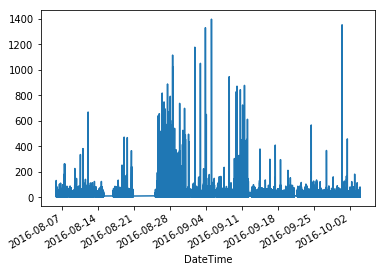

In [14]:
merged_df['mean_kurtosis'].plot()

In [ ]:
merged_df['M3_20_Avg_interp'].plot()

In [ ]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline

In [ ]:
merged_df['mean_mean'].plot()

In [ ]:
#These timseries are very spikey! might need to apply a filter to reduce these 
from ts_tools import despike_np_array

In [ ]:
ar = despike_np_array(merged_df['mean_kurtosis'].values,scale_factor=10)

In [ ]:
merged_df['mean_kurtosis_despiked'] = ar

In [ ]:
merged_df['mean_kurtosis_despiked'].plot()

In [ ]:
merged_df['mean_kurtosis'].plot()

In [ ]:
import scipy.signal

In [ ]:
arr = scipy.signal.medfilt(merged_df['mean_kurtosis'].values,5)

In [ ]:
plt.plot(arr[:7200])

In [ ]:
#It really looks like theres a day/night cycle going on here. We might want to see if we can predict this

In [15]:
soil_M_temp = pd.read_csv("Fnames_soilM_temp.csv")

In [18]:
soil_M_temp.head()

,file_name,Line,Timestamp,DateTime,tsince_start_soilM,M1_20_Avg_interp,M2_20_Avg_interp,M3_20_Avg_interp,M4_10_Avg_interp,M4_35_Avg_interp,...,M7_20_Avg_interp,M7_35_Avg_interp,M8_20_Avg_interp,M9_20_Avg_interp,M9_35_Avg_interp,tsince_start_temp,Temphigh_interp,Humidhigh_interp,Humidlow_interp,Battvolt_interp
0,./20160805180738_40_Hz_LineC,LineC,20160805180738,2016-08-05 18:07:38,21488.0,0.581,0.61056,0.202,0.533,0.497813,...,0.558187,0.562,0.311,0.417,0.495187,756488.0,27.437489,45.485533,0.0,12.74
1,./20160805180738_40_Hz_LineCSN.mseed,LineCSN,20160805180738,2016-08-05 18:07:38,21488.0,0.581,0.61056,0.202,0.533,0.497813,...,0.558187,0.562,0.311,0.417,0.495187,756488.0,27.437489,45.485533,0.0,12.74
2,./20160805180738_40_Hz_Line2EW.mseed,Line2EW,20160805180738,2016-08-05 18:07:38,21488.0,0.581,0.61056,0.202,0.533,0.497813,...,0.558187,0.562,0.311,0.417,0.495187,756488.0,27.437489,45.485533,0.0,12.74
3,./20160805180738_40_Hz_Line2,Line2,20160805180738,2016-08-05 18:07:38,21488.0,0.581,0.61056,0.202,0.533,0.497813,...,0.558187,0.562,0.311,0.417,0.495187,756488.0,27.437489,45.485533,0.0,12.74
4,./20160805180838_40_Hz_Line2EW.mseed,Line2EW,20160805180838,2016-08-05 18:08:38,21548.0,0.581,0.61026,0.202,0.533,0.497913,...,0.558087,0.562,0.311,0.417,0.495087,756548.0,27.423656,45.512033,0.0,12.74


In [19]:
soil_M_temp.reset_index(drop=True,inplace=True)
lineCSN_temp = soil_M_temp[soil_M_temp['Line'] == "LineCSN"]
lineCSN_temp['DateTime'] = pd.to_datetime(lineCSN_temp['DateTime'])
lineCSN_temp.set_index('DateTime',inplace=True)

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
lineCSN_temp.head()

,file_name,Line,Timestamp,tsince_start_soilM,M1_20_Avg_interp,M2_20_Avg_interp,M3_20_Avg_interp,M4_10_Avg_interp,M4_35_Avg_interp,M5_20_Avg_interp,...,M7_20_Avg_interp,M7_35_Avg_interp,M8_20_Avg_interp,M9_20_Avg_interp,M9_35_Avg_interp,tsince_start_temp,Temphigh_interp,Humidhigh_interp,Humidlow_interp,Battvolt_interp
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-08-05 18:07:38,./20160805180738_40_Hz_LineCSN.mseed,LineCSN,20160805180738,21488.0,0.581000,0.610560,0.202000,0.533,0.497813,0.318,...,0.558187,0.562,0.311,0.417,0.495187,756488.0,27.437489,45.485533,0.0,12.74
2016-08-05 18:08:38,./20160805180838_40_Hz_LineCSN.mseed,LineCSN,20160805180838,21548.0,0.581000,0.610260,0.202000,0.533,0.497913,0.318,...,0.558087,0.562,0.311,0.417,0.495087,756548.0,27.423656,45.512033,0.0,12.74
2016-08-05 18:09:38,./20160805180938_40_Hz_LineCSN.mseed,LineCSN,20160805180938,21608.0,0.580987,0.610027,0.202013,0.533,0.498000,0.318,...,0.558000,0.562,0.311,0.417,0.494987,756608.0,27.409822,45.538533,0.0,12.74
2016-08-05 18:10:38,./20160805181038_40_Hz_LineCSN.mseed,LineCSN,20160805181038,21668.0,0.580887,0.610227,0.202113,0.533,0.498000,0.318,...,0.558000,0.562,0.311,0.417,0.494887,756668.0,27.395989,45.565033,0.0,12.74
2016-08-05 18:11:38,./20160805181138_40_Hz_LineCSN.mseed,LineCSN,20160805181138,21728.0,0.580787,0.610427,0.202213,0.533,0.498000,0.318,...,0.558000,0.562,0.311,0.417,0.494787,756728.0,27.382156,45.591533,0.0,12.74


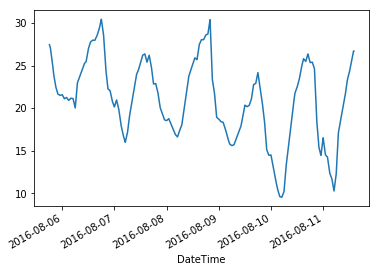

In [30]:
lineCSN_temp['Temphigh_interp'][:7200].plot()

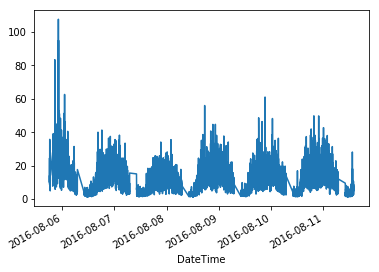

In [28]:
merged_df['mean_iqr'][:7200].plot()

There is definity a correlation here. Spikey data might pose a problem though - will need to think about a good despiking method, either for the data or the features time series. 